### IMPORT LIBRARY

Mengimport berbagai library dan modul sangat diperlukan untuk membangun, melatih, dan mengevaluasi model klasifikasi gambar menggunakan Keras (bagian dari TensorFlow). Library seperti NumPy dan Pandas digunakan untuk manipulasi data, sementara Matplotlib digunakan untuk visualisasi. OpenCV dan OS digunakan untuk pemrosesan gambar dan operasi file. TensorFlow/Keras menyediakan alat untuk membangun model neural network (dengan lapisan seperti Conv2D, MaxPooling2D, dll.), memproses gambar (dengan ImageDataGenerator), dan mengoptimalkan pelatihan (dengan optimizer Adam dan callback EarlyStopping). Scikit-Learn digunakan untuk evaluasi model melalui metrik seperti confusion matrix dan classification report. Glob digunakan untuk mencari file dengan pola tertentu dalam sistem file.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import  img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from glob import glob


### LOAD DATASET

Mengakses dataset yang sudah di download dari laman kaggle : https://www.kaggle.com/datasets/techsash/waste-classification-data. Dataset ini disimpan dalam direktori yang sama yang bernama DATASET. Lalu data training diambil dari folder TRAIN dan data testing diambil dari folder TEST.

In [39]:
train_path = "DATASET/TRAIN/"
test_path = "DATASET/TEST/"

Kemudian dilakukan proses membaca dan memproses gambar dari folder training, menyimpannya dalam list x_data dan labelnya dalam y_data. Untuk setiap kategori dalam folder train_path, ia mencari semua file gambar, membacanya menggunakan OpenCV (cv2.imread), mengonversi warna dari BGR ke RGB (cv2.cvtColor), dan menambahkannya ke list x_data. Label untuk setiap gambar diambil dari nama folder kategori dan disimpan dalam y_data. Setelah semua gambar dan label dikumpulkan, keduanya digabungkan menjadi suatu variabel yang bernama "data" dengan dua kolom: 'image' yang berisi array gambar dan 'label' yang berisi label kategori.

In [40]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 9999/9999 [00:53<00:00, 188.10it/s]


Kemudian, melihat ukuran dari data yang dimiliki dengan fungsi shape.

In [41]:
data.shape

(22564, 2)

Membuat pie chart untuk melihat isi dari data yang akan digunakan dalam proses training.

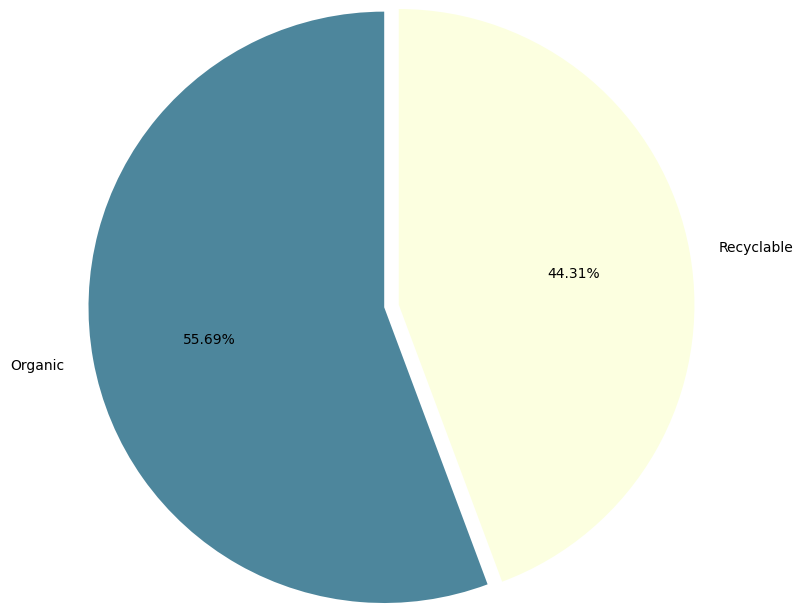

In [44]:
colors = ['#4D869C','#FCFFE0']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

Ternyata, data tersebut stabil dan imbang antara 2 kelasnya sehingga data ini dapat dikatakan layak untuk digunakan dalam proses training data. Data ini tidak oversampling atau pun undersampling.

Proses selanjutnya adalah melihat sample dari data yang dimiliki.

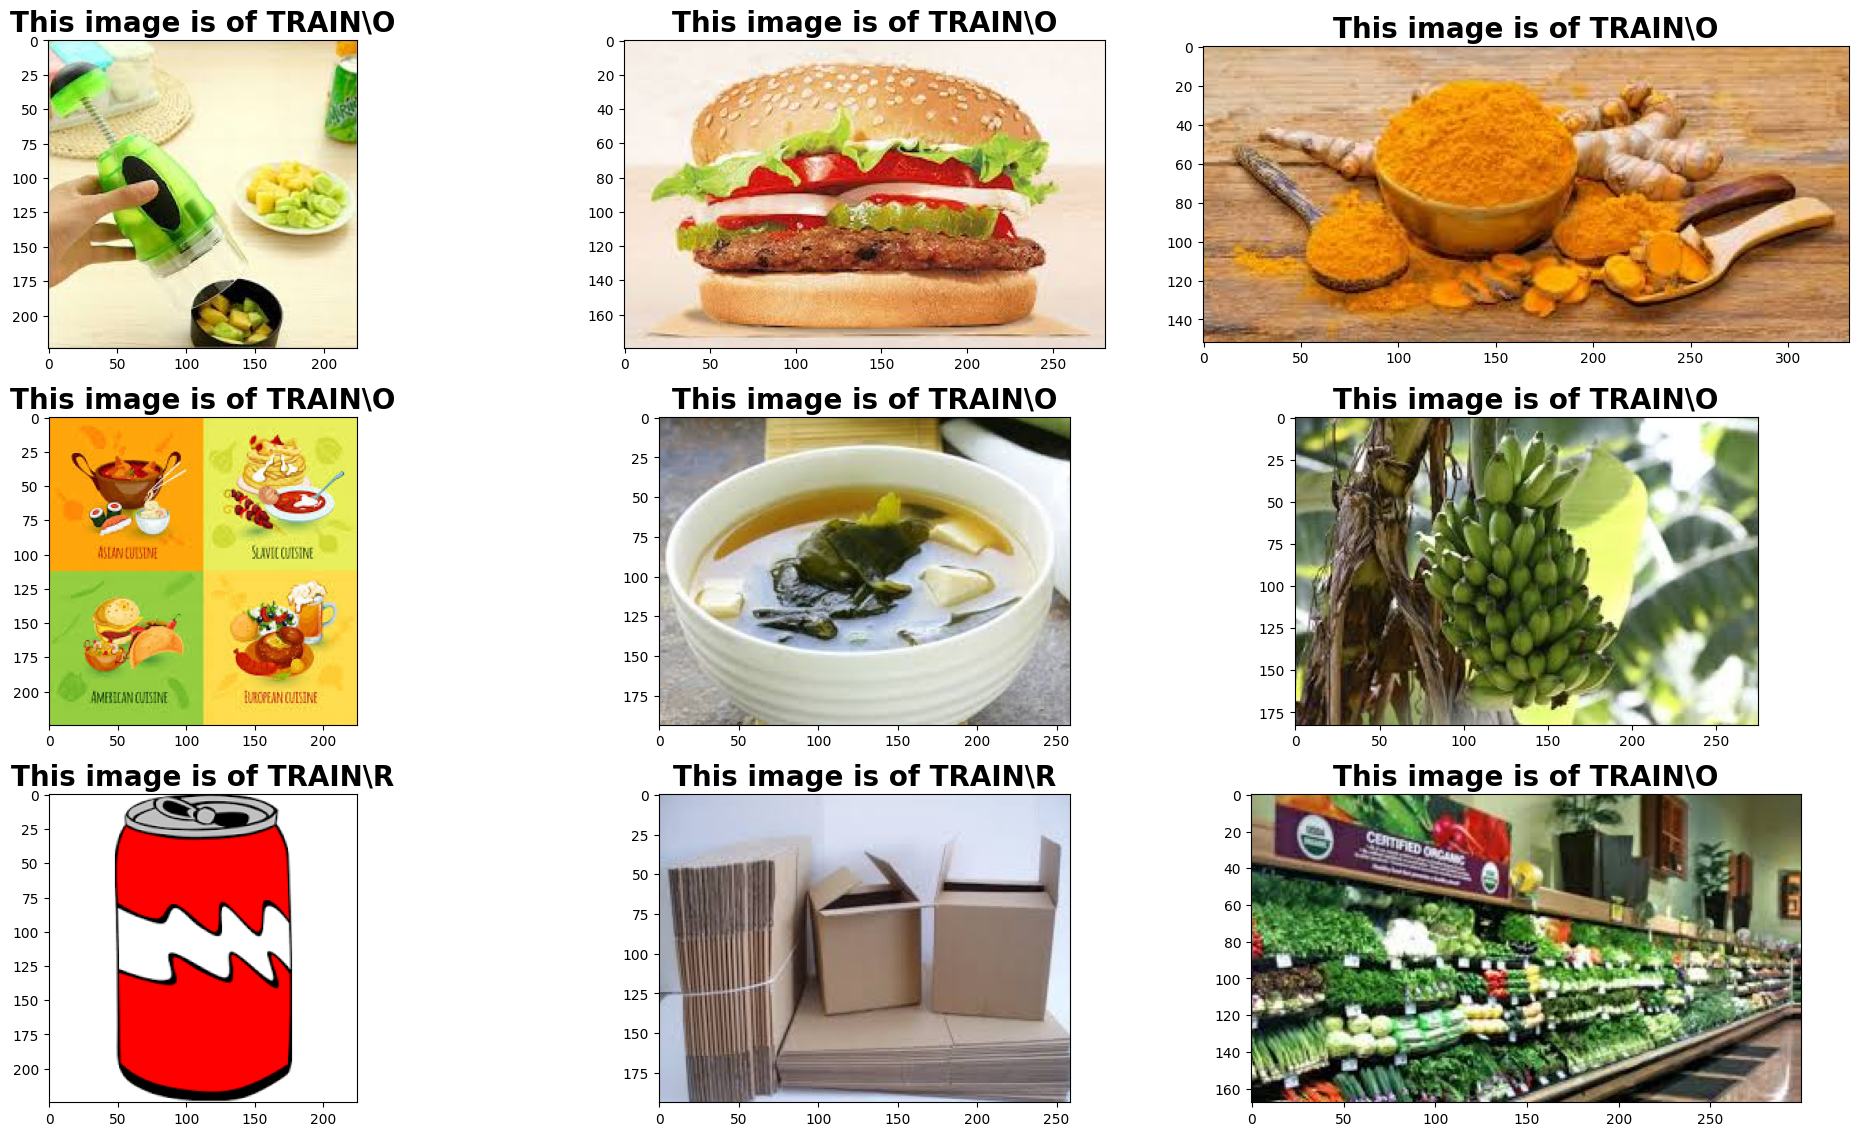

In [45]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [46]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


Dari output diatas, dapat dilihat bahwa data yang ada dalam folder train/R dan train/O adalah data yang benar. *R* untuk data sampah yang dapat di *recycle* dan *O* untuk data sampah *organic* yang artinya data ini memiliki 2 class.

### BANGUN MODEL

Dalam konteks data yang dimiliki, model yang paling baik dalam mengklasifikasi gambar adalah model dengan arsitektur Convolutional Neural Network (CNN). Proses pembuatan arsitektur CNN menggunakan beberapa layer seperti Conv2D, Maxpooling2D, Flatten, Dense dan juga Dropout. Masing-masing layer memiliki fungsi dan tujuannya masing-masing dalam memahami dataset. Layer pertama harus menyertakan input shape dari dimensi gambar yang dimiliki oleh data. Layer paling akhir harus menyesuaikan dengan label dari data.

In [47]:
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape = (224,224,3), activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3), activation="relu"))  
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3), activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass, activation="sigmoid")) # output

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

batch_size = 256

c:\Users\LENOVO\Documents\KULIAH\Semester 6\Pembelajaran Mesin\Final-Lab\final-lab-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model yang telah dibuat dapat dilihat arsitektur nya serta paramater yang ada dengan fungsi summary.

In [4]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,261,252 (84.92 MB)

 Trainable params: 22,261,250 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Dari summary diatas, dapat dilihat bahwa : 
1. Jumlah Hidden Layer 
Ada tiga lapisan konvolusi dan dua lapisan Dense, sehingga jumlah total hidden layer adalah lima.

2. Total Hidden Node per Layer
Lapisan Konvolusi 1 (Conv2D): 32 node
Lapisan Konvolusi 2 (Conv2D): 64 node
Lapisan Konvolusi 3 (Conv2D): 128 node
Lapisan Dense 1 (Dense): 256 node
Lapisan Dense 2 (Dense): 64 node

3. Total bobot (weight)
Total params mencakup jumlah semua parameter yang dapat disesuaikan dalam model, termasuk bobot (weights) dan bias dalam semua lapisan. Dalam konteks model diatas, total params adalah 22,261,252. Sehingga, jumlah weight dalam model ini adalah 22,261,252.

Dalam model ini, ReLU digunakan di lapisan konvolusi dan lapisan-lapisan Dense untuk memungkinkan model untuk mempelajari pola yang lebih kompleks dan memperkenalkan kompleksitas ke dalam struktur model, sedangkan Sigmoid digunakan di output layer untuk menghasilkan probabilitas kelas positif pada binary classification.

### Preprocessing Gambar dalam Generator

#### Normalisasi Data

In [48]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [49]:
test_datagen = ImageDataGenerator(rescale= 1./255)

Tahap ini bertujuan untuk menormalisasikan data agar semuanya memiliki nilai piksel dalam rentang yang sama. Dalam konteks penggunaan ImageDataGenerator, normalisasi dilakukan dengan mengurangi nilai piksel gambar dengan 255. Hal ini dilakukan untuk menyebarkan nilai piksel menjadi rentang antara 0 dan 1.
Normalisasi adalah langkah penting dalam pra-pemrosesan data karena dapat membantu meningkatkan kestabilan dan konvergensi pelatihan model, serta menghindari masalah numerik yang mungkin terjadi selama pelatihan.

In [50]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


Pembuatan generator data latih (train_generator) dilakukan dengan menggunakan train_datagen.flow_from_directory(). Pada tahap ini, ditentukan lokasi (train_path) dari dataset gambar latih yang telah diorganisir dalam struktur direktori berdasarkan kelas-kelasnya. Setelah itu, ditetapkan ukuran yang diharapkan untuk gambar input dengan parameter target_size, dalam hal ini adalah 224x224 piksel. Selain itu, ditentukan jumlah sampel gambar yang akan dihasilkan dalam setiap batch (batch_size). Warna gambar ditentukan dengan parameter color_mode, yang diatur sebagai "rgb". Terakhir, dengan menetapkan class_mode sebagai "categorical", generator akan menghasilkan batch-batch data gambar latih beserta label kelasnya dalam format yang sesuai untuk pelatihan model.

Proses yang serupa juga dilakukan untuk pembuatan generator data uji (test_generator). 

Dengan menggunakan generator data seperti ini, akan mudah memuat dan mengelola dataset yang besar tanpa memuat keseluruhan dataset ke dalam memori, yang berguna terutama saat bekerja dengan gambar-gambar yang memiliki ukuran besar.

### Proses Training Data

Melatih model dengan train generator sebagai input x dan test generator sebagai validasi dalam mengevaluasi performa.

In [51]:
hist = model.fit(
    x=train_generator,
    epochs=15,
    validation_data=test_generator
)


Epoch 1/15


c:\Users\LENOVO\Documents\KULIAH\Semester 6\Pembelajaran Mesin\Final-Lab\final-lab-env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 444s 5s/step - accuracy: 0.7360 - loss: 0.6062 - val_accuracy: 0.8428 - val_loss: 0.3877
Epoch 2/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.8320 - loss: 0.4091 - val_accuracy: 0.8942 - val_loss: 0.2875
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 391s 4s/step - accuracy: 0.8494 - loss: 0.3669 - val_accuracy: 0.8500 - val_loss: 0.3320
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 397s 4s/step - accuracy: 0.8701 - loss: 0.3264 - val_accuracy: 0.8969 - val_loss: 0.2843
Epoch 5/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 428s 5s/step - accuracy: 0.8798 - loss: 0.3063 - val_accuracy: 0.8977 - val_loss: 0.2723
Epoch 6/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 403s 5s/step - accuracy: 0.8911 - loss: 0.2697 - val_accuracy: 0.8870 - val_loss: 0.2856
Epoch 7/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 392s 4s/step - accuracy: 0.9063 - loss: 0.2430 - val_accuracy: 0.8997 - val_loss: 0.2664
Epoch 8/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.9256 - loss: 0.2005 - val_accuracy: 0.8914 - val_loss: 0.

Tujuan dari kode di atas adalah untuk melatih model neural network menggunakan data latih yang telah diatur dalam bentuk generator (train_generator) dan mengevaluasi performa model menggunakan data uji (test_generator). Proses ini dilakukan selama 15 epoch, di mana model akan mencoba untuk mempelajari pola-pola yang ada dalam data latih dan meningkatkan performa berdasarkan evaluasi pada data uji. Hasil dari pelatihan ini akan disimpan dalam variabel hist, yang nantinya dapat digunakan untuk menganalisis performa dan proses pelatihan model tersebut.

Hasil dari pelatihan data ini, model mampu memiliki acc saat training senilai 98% dan divalidasi acc tersebut senilai 88%. Nilai loss pada model saat di training juga sebanyak 0.05 atau 5% dan validasi nya 0,5 atau 50%. Semakin rendah nilai loss maka model dapat dikatakan semakin membaik.

Berikut plot dari hist model dalam proses pelatihan:

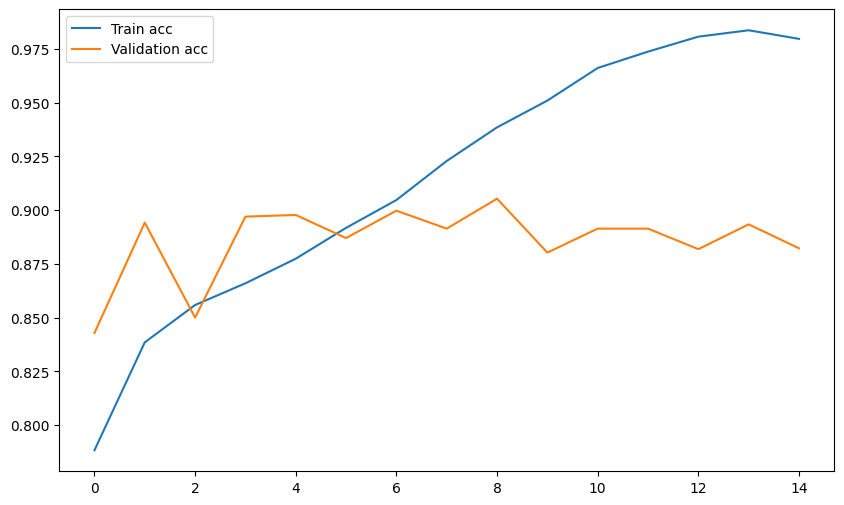

In [52]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

Akurasi pada data pelatihan yang semakin naik hingga mendekati 1 yaitu 98% menunjukkan bahwa model mampu dengan baik untuk mempelajari pola-pola yang ada dalam data pelatihan.
Namun, akurasi pada data validasi yang lebih rendah (88%) menunjukkan bahwa model tidak generalisasi dengan baik pada data baru yang tidak terlihat sebelumnya, yang mungkin disebabkan oleh memorisasi pola-pola kecil atau noise yang ada dalam data pelatihan.
Meskipun akurasi pada data validasi (88%) lebih rendah dari akurasi pada data pelatihan (98%), hasil ini masih bisa dianggap baik tergantung pada konteks aplikasi dan dataset yang digunakan.

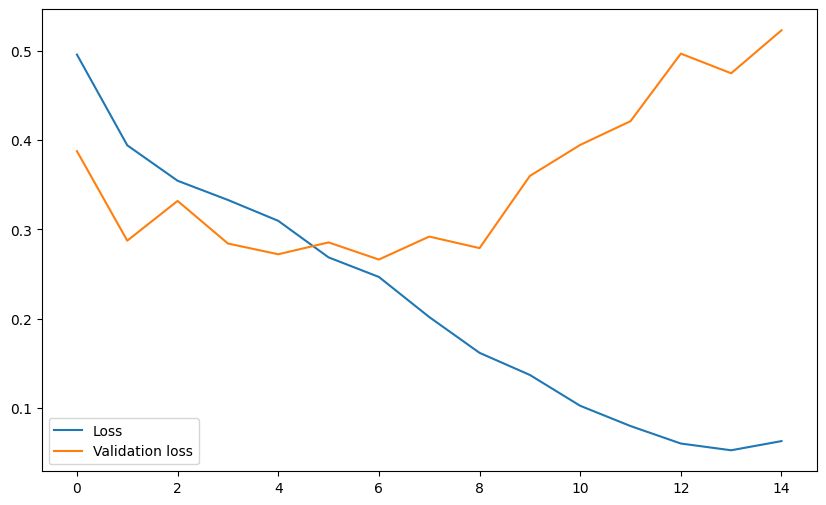

In [53]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["loss"], label = "Loss")
plt.plot(hist.history["val_loss"], label = "Validation loss")
plt.legend()
plt.show()

Nilai loss sudah menurun dan menjadi sangat rendah yang artinya pada proses training model dapat prediksi dengan akurat. Namun saat dilakukan validasi loss, model tidak sepenuhnya mampu prediksi, maka dari itu nilai val loss nya tidak mendekati 1, hanya mampu diatas 0.5. 

### Evaluasi Model

Dalam memprediksi gambar pada data testing, model mampu memprediksi 13 gambar dengan benar dan 2 gambar yang salah. Untuk konteks aplikasi klasifikasi sampah organic dan recycle, kemampuan ini dirasa cukup karena prediksi salah ini terlalu berarti jika jumlah nya sedikit. 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


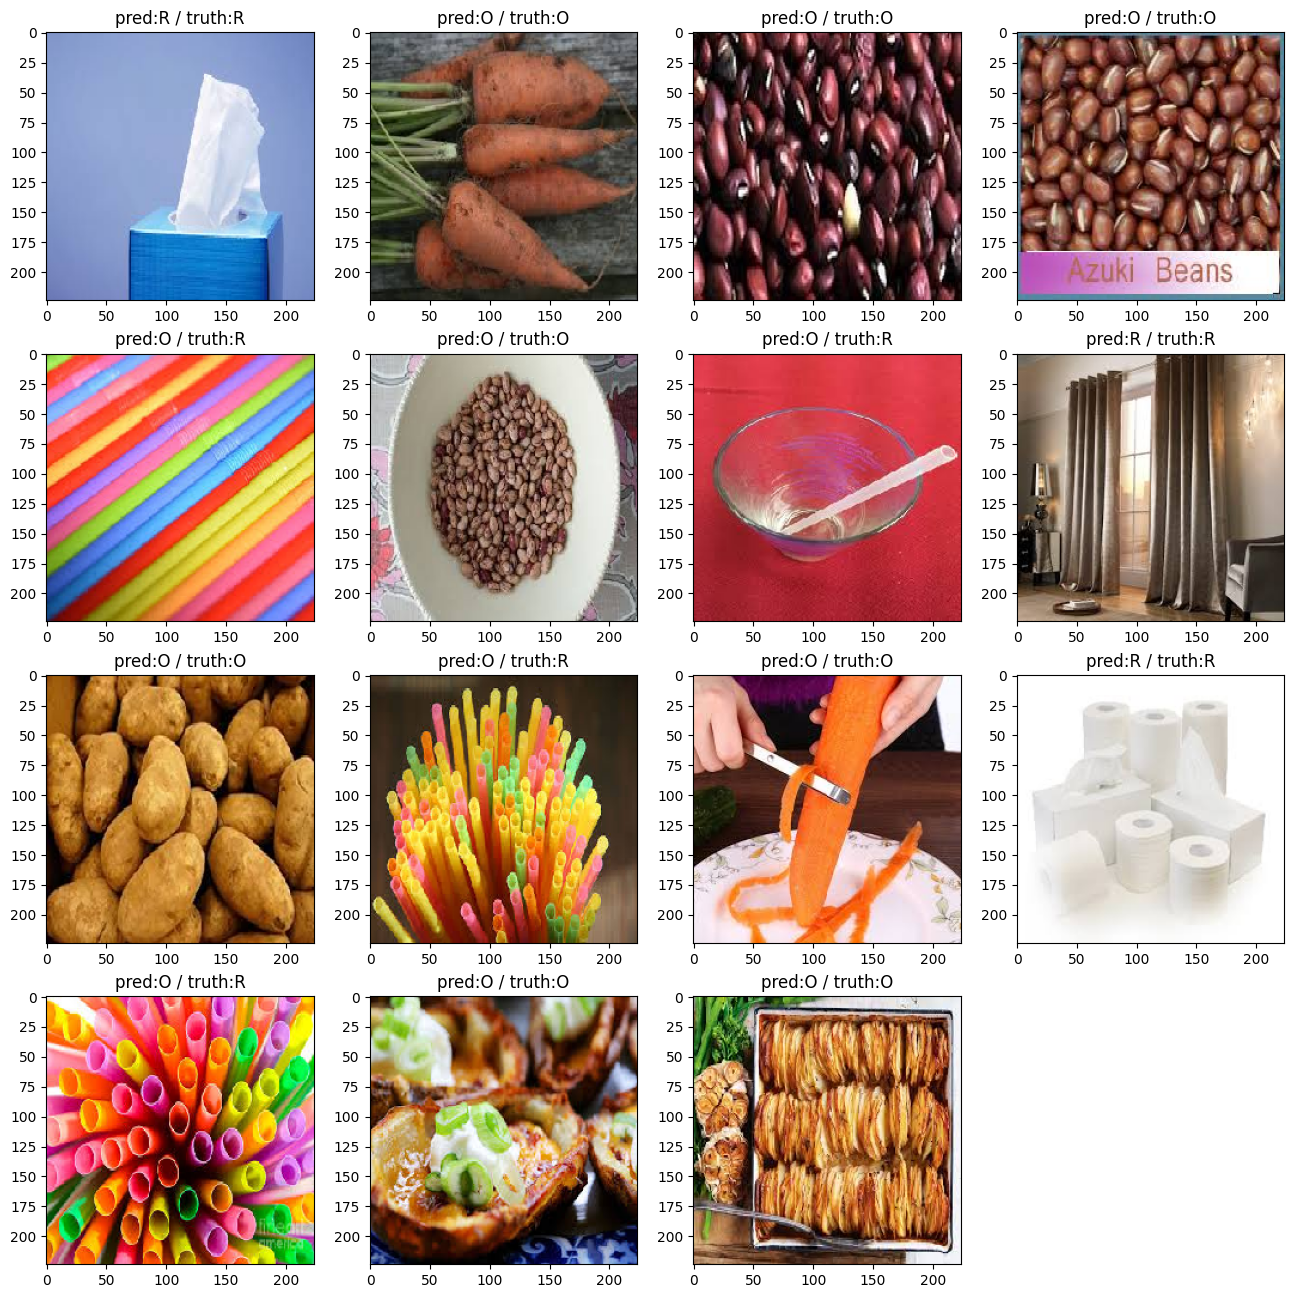

In [54]:
test_x, test_y = test_generator.__getitem__(1)

labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(15):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

Save model untuk dapat digunakan dalam proses selanjutnya yaitu deploy.

In [55]:
model.save('final_cnn.h5')

#### Confusion Matrix

Matriks ini digunakan untuk melihat hasil prediksi model dengan data aslinya. 

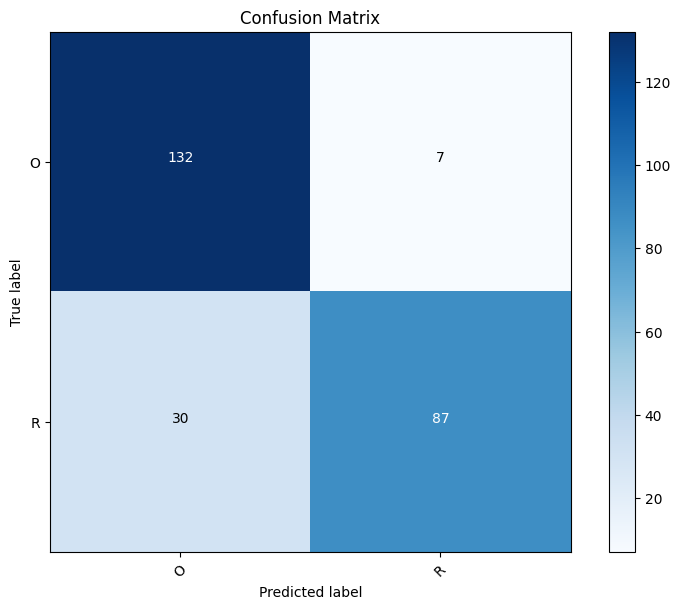

In [56]:
# Mengubah prediksi dan label sebenarnya menjadi bentuk yang sesuai
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(test_y, axis=1)

# Membuat matriks kebingungan
confusion_mtx = confusion_matrix(true_classes, pred_classes)

# Plot matriks kebingungan dengan menambahkan teks ke setiap sel
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Menambahkan teks ke setiap sel
thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, format(confusion_mtx[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels.values(), rotation=45)
plt.yticks(tick_marks, labels.values())
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Pada confusion matrix diatas, model mampu dengan benar memprediksi kelas O yang sebenarnya adalah O sebanyak 132 gambar. Gambar O tapi diprediksi menjadi R sebanyak 7 gambar, gambar R diprediksi menjadi O sebanyak 30 gambar. Namun gambar R diprediksi menjadi R juga mendominasi yaitu 87 gambar.

Classification report akan memberikan ringkasan dari metrik evaluasi untuk model klasifikasi biner, dengan dua kelas yang diberi label 'O' dan 'R'.

In [57]:
# Membuat laporan klasifikasi
report = classification_report(true_classes, pred_classes, target_names=labels.values())

print(report)

              precision    recall  f1-score   support

           O       0.81      0.95      0.88       139
           R       0.93      0.74      0.82       117

    accuracy                           0.86       256
   macro avg       0.87      0.85      0.85       256
weighted avg       0.87      0.86      0.85       256



Precision (Presisi):

- Untuk kelas 'O': 0.81
Dari semua prediksi model yang diklasifikasikan sebagai 'O', 81% adalah benar-benar 'O'.
- Untuk kelas 'R': 0.93
Dari semua prediksi model yang diklasifikasikan sebagai 'R', 93% adalah benar-benar 'R'.

Recall (Daya Ingat/Sensitivitas):

- Untuk kelas 'O': 0.95
Dari semua data yang benar-benar 'O', 95% berhasil diidentifikasi oleh model.
- Untuk kelas 'R': 0.74
Dari semua data yang benar-benar 'R', 74% berhasil diidentifikasi oleh model.

F1-Score:

- Untuk kelas 'O': 0.88
Gabungan dari presisi dan recall memberikan nilai rata-rata 0.88 untuk kelas 'O'.
- Untuk kelas 'R': 0.82
Gabungan dari presisi dan recall memberikan nilai rata-rata 0.82 untuk kelas 'R'.

Accuracy (Akurasi):

Akurasi keseluruhan model adalah 0.86 atau 86%, yang berarti model secara keseluruhan berhasil mengklasifikasikan 86% dari total sampel dengan benar.

Secara keseluruhan, classification report ini menunjukkan bahwa model memiliki performa yang baik dengan akurasi keseluruhan 86%. Model lebih baik dalam mengklasifikasikan kelas 'O' dibandingkan kelas 'R', terlihat dari presisi dan recall yang lebih tinggi pada kelas 'O'.

In [58]:
model.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8766 - loss: 0.5268


[0.5230391025543213, 0.8822125196456909]

Nilai pertama (0.5230391025543213) adalah nilai loss pada data uji. Ini menunjukkan seberapa baik atau buruk model memprediksi label yang benar untuk data uji.
Nilai kedua (0.8822125196456909) adalah nilai akurasi pada data uji. Ini menunjukkan proporsi sampel yang diklasifikasikan dengan benar oleh model.
Akurasi sebesar 88.22% menunjukkan bahwa model mampu memprediksi dengan benar sekitar 88.22% dari data uji.
Secara keseluruhan, hasil evaluasi ini menunjukkan bahwa model memiliki performa yang baik pada data uji dengan akurasi yang cukup tinggi, namun masih terdapat ruang untuk perbaikan.